In [1]:
# enhanced_models_with_gridsearch_and_dl.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, utils

import pickle


In [2]:
LABELS = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']



In [3]:
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    X_train = train.drop(columns=['subject', 'Activity', 'ActivityName'], errors='ignore')
    y_train = train['ActivityName']
    X_test = test.drop(columns=['subject', 'Activity', 'ActivityName'], errors='ignore')
    y_test = test['ActivityName']
    return X_train, y_train, X_test, y_test



In [4]:
def plot_conf_matrix(cm, class_names, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()



In [5]:
def evaluate_model(name, grid, X_train, y_train, X_test, y_test):
    print(f"\n🔍 Grid Search: {name}")
    grid.fit(X_train, y_train)  # fit once
    print(f"✅ Best params for {name}: {grid.best_params_}")

    y_pred = grid.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    cm = metrics.confusion_matrix(y_test, y_pred)
    class_labels = sorted(np.unique(y_test))
    plot_conf_matrix(cm, class_labels, normalize=True)

    print(f"\n🎯 Accuracy for {name}: {acc:.4f}")
    print(metrics.classification_report(y_test, y_pred))
    return acc, grid.best_estimator_


In [6]:

def run_grid_search_models(X_train, y_train, X_test, y_test, filename='best_model.pkl'):
    models = {
        "Logistic Regression": {
            "model": LogisticRegression(max_iter=1000),
            "params": {"C": [0.1, 1, 10, 30, 50], "solver": ["lbfgs"], "penalty": ["l2"]}
        },
        "SVM": {
            "model": SVC(),
            "params": {"C": [1, 10, 20], "kernel": ["rbf", "linear"]}
        },
        "KNN": {
            "model": KNeighborsClassifier(),
            "params": {"n_neighbors": [3, 5, 7]}
        },
        "Random Forest": {
            "model": RandomForestClassifier(),
            "params": {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
        },
            "MLP": {
                "model": MLPClassifier(max_iter=300),
                "params": {"hidden_layer_sizes": [(100,), (50, 50)], "activation": ["relu", "tanh"]}
        }
    }

    best_model = None
    best_score = -1
    best_name = ""

    for name, config in models.items():
        grid = GridSearchCV(config["model"], config["params"], cv=3, n_jobs=-1, verbose=1)
        acc, best_estimator = evaluate_model(name, grid, X_train, y_train, X_test, y_test)

        if acc > best_score:
            best_score = acc
            best_model = best_estimator
            best_name = name

    print(f"\n🏆 Best Model: {best_name} with Accuracy: {best_score:.4f}")

    if best_model:
        with open(filename, 'wb') as f:
            pickle.dump(best_model, f)
        print(f"✅ Best model saved to '{filename}'")

    return best_model, best_name, best_score

In [7]:
def run_deep_learning_model(X_train, y_train, X_test, y_test):
    print("\n🧠 Training Deep Learning Model with Keras")

    # Encode labels
    label_map = {label: idx for idx, label in enumerate(np.unique(y_train))}
    y_train_enc = utils.to_categorical([label_map[y] for y in y_train])
    y_test_enc = utils.to_categorical([label_map[y] for y in y_test])

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(LABELS), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_enc, validation_split=0.2,
                        epochs=100, batch_size=64, verbose=1)

    loss, acc = model.evaluate(X_test_scaled, y_test_enc)
    print(f"\n🎯 Deep Learning Test Accuracy: {acc:.4f}")

    # Predict & Plot Confusion Matrix
    y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
    y_true = np.argmax(y_test_enc, axis=1)
    cm = metrics.confusion_matrix(y_true, y_pred)
    plot_conf_matrix(cm, LABELS, normalize=True)



In [8]:

'''
def pca_transform(X_train, X_test, variance_threshold=0.99):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA()
    pca.fit(X_train_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"🧪 PCA: Retaining {n_components} components for {variance_threshold*100:.0f}% variance")
    pca_final = PCA(n_components=n_components)
    return pca_final.fit_transform(X_train_scaled), pca_final.transform(X_test_scaled)

'''

'\ndef pca_transform(X_train, X_test, variance_threshold=0.99):\n    scaler = StandardScaler()\n    X_train_scaled = scaler.fit_transform(X_train)\n    X_test_scaled = scaler.transform(X_test)\n    pca = PCA()\n    pca.fit(X_train_scaled)\n    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)\n    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1\n    print(f"🧪 PCA: Retaining {n_components} components for {variance_threshold*100:.0f}% variance")\n    pca_final = PCA(n_components=n_components)\n    return pca_final.fit_transform(X_train_scaled), pca_final.transform(X_test_scaled)\n\n'


🔍 Grid Search: Logistic Regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best params for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


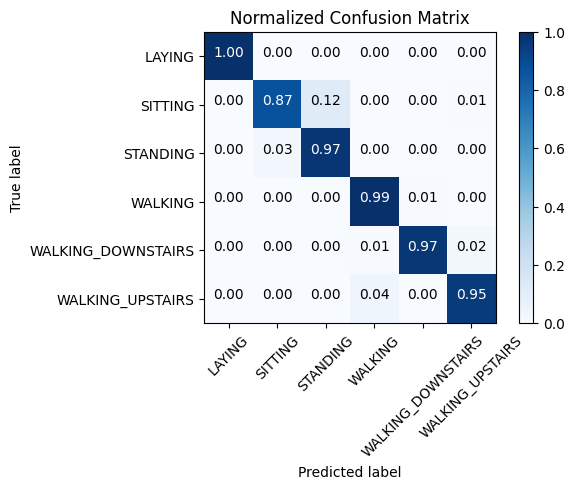


🎯 Accuracy for Logistic Regression: 0.9617
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.87      0.92       491
          STANDING       0.90      0.97      0.94       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947


🔍 Grid Search: SVM
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best params for SVM: {'C': 20, 'kernel': 'rbf'}


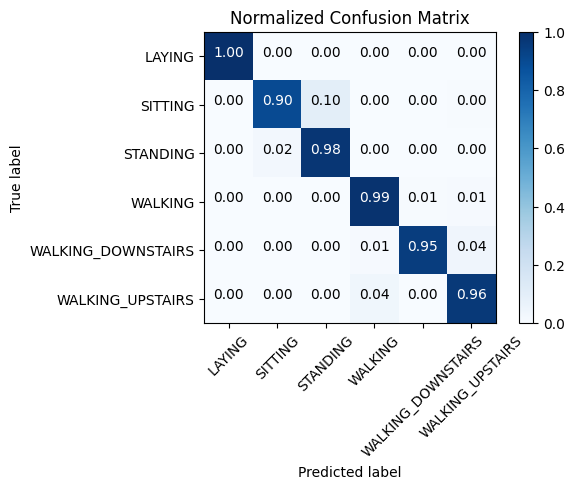


🎯 Accuracy for SVM: 0.9623
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.91      0.98      0.94       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947


🔍 Grid Search: KNN
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✅ Best params for KNN: {'n_neighbors': 7}


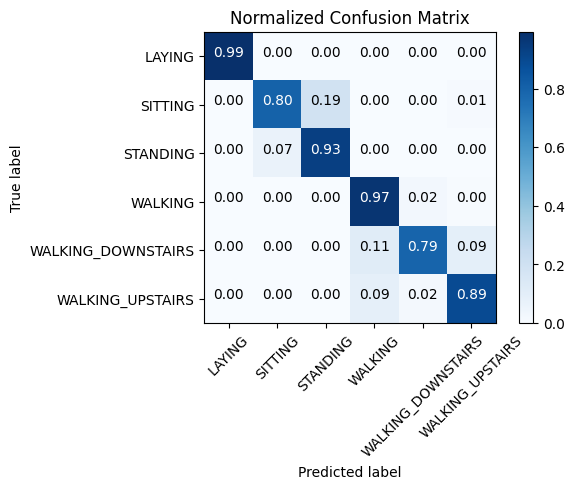


🎯 Accuracy for KNN: 0.9023
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.91      0.80      0.85       491
          STANDING       0.84      0.93      0.89       532
           WALKING       0.84      0.97      0.90       496
WALKING_DOWNSTAIRS       0.94      0.79      0.86       420
  WALKING_UPSTAIRS       0.90      0.89      0.90       471

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947


🔍 Grid Search: Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best params for Random Forest: {'max_depth': None, 'n_estimators': 200}


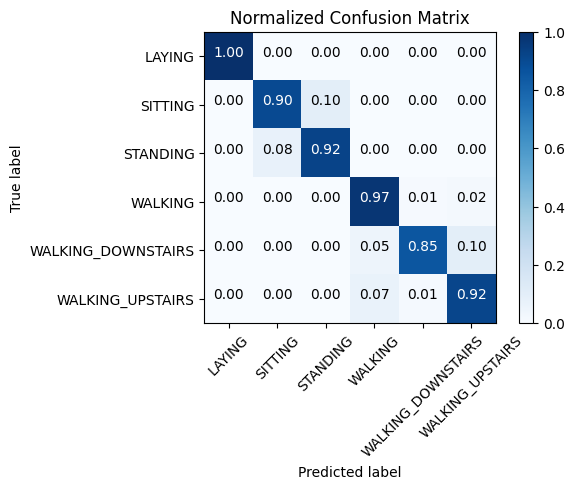


🎯 Accuracy for Random Forest: 0.9311
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.90      0.91       491
          STANDING       0.91      0.92      0.92       532
           WALKING       0.90      0.97      0.94       496
WALKING_DOWNSTAIRS       0.97      0.85      0.91       420
  WALKING_UPSTAIRS       0.90      0.92      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947


🔍 Grid Search: MLP
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best params for MLP: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}


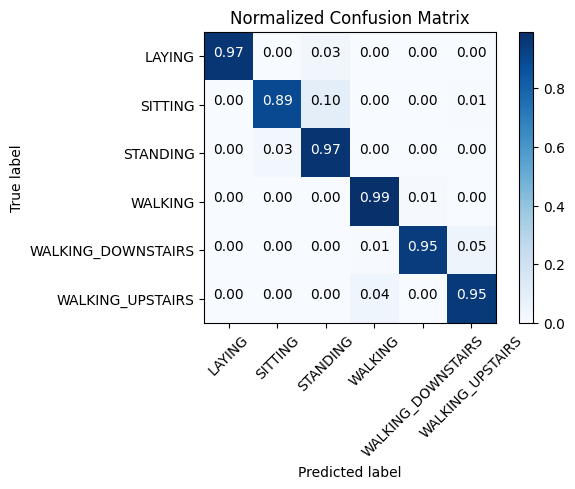


🎯 Accuracy for MLP: 0.9545
                    precision    recall  f1-score   support

            LAYING       1.00      0.97      0.98       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.95      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947


🏆 Best Model: SVM with Accuracy: 0.9623
✅ Best model saved to 'best_model.pkl'


In [13]:

    # Grid Search for ML Models
best_model, best_name, best_score = run_grid_search_models(X_train, y_train, X_test, y_test)





🧠 Training Deep Learning Model with Keras


C:\Users\Semi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6774 - loss: 0.8039 - val_accuracy: 0.9225 - val_loss: 0.2402
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9287 - loss: 0.1843 - val_accuracy: 0.9293 - val_loss: 0.1762
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9576 - loss: 0.1155 - val_accuracy: 0.9375 - val_loss: 0.1659
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9648 - loss: 0.0960 - val_accuracy: 0.9273 - val_loss: 0.2324
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9747 - loss: 0.0754 - val_accuracy: 0.9327 - val_loss: 0.2112
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.0578 - val_accuracy: 0.9347 - val_loss: 0.2160
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9814 - loss: 0.0545 - val_accuracy: 0.9415 - val_loss: 0.1596
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0554 - val_accuracy: 0.9320 - v

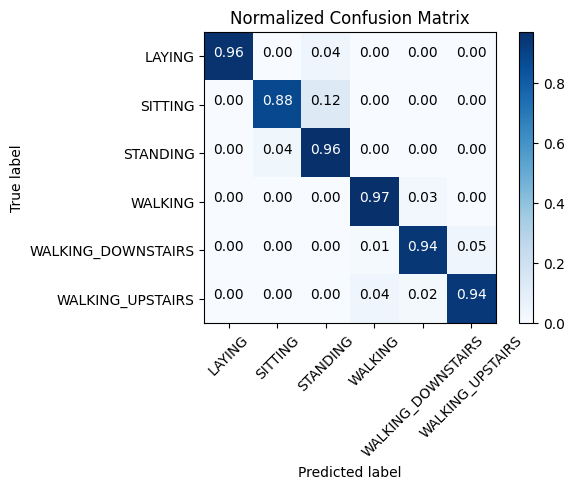

In [10]:
  # Deep Learning
run_deep_learning_model(X_train, y_train, X_test, y_test)

In [11]:

# Load the model
with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Use the model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print("✅ Accuracy:", accuracy)


✅ Accuracy: 0.9623345775364778


In [14]:
print("🏷️ Best model name:", best_name)
print("🧠 Best model object:\n", best_model)


🏷️ Best model name: SVM
🧠 Best model object:
 SVC(C=20)
